<a href="https://colab.research.google.com/github/JaredRob/COMP2211/blob/main/Behaviour_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/JaredRob/TrackData

Cloning into 'TrackData'...
remote: Enumerating objects: 14689, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 14689 (delta 1), reused 0 (delta 0), pack-reused 14683
Receiving objects: 100% (14689/14689), 216.91 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (14682/14682), done.


In [3]:
!ls TrackData

Behaviour_Cloning.ipynb  driving_log.csv  IMG  README.md


In [4]:
import os
import numpy as np
print("numpy:" + np.__version__)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
print("keras:" + keras.__version__)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
print("cv2:" + cv2.__version__)
import pandas as pd
import random
import ntpath

numpy:1.21.6
keras:2.9.0
cv2:4.6.0


In [5]:
datadir = 'TrackData'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  \
0  C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_397.jpg   
1  C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_498.jpg   
2  C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_603.jpg   
3  C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_703.jpg   
4  C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_810.jpg   

                                                                left  \
0   C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_397.jpg   
1   C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_498.jpg   
2   C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_603.jpg   
3   C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_703.jpg   
4   C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_810.jpg   

                                                                right  \
0   C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_397.jpg   
1   C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_498.jpg   
2   C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_603.jpg   
3   C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_703.jpg   
4   C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_810.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0        0.000078  
1  0.0       0.0       0        0.000078  
2  0.0       0.0       0        0.000081  
3  0.0       0.0       0        0.000080  
4  0.0       0.0       0        0.000078

In [6]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2022_10_31_21_11_18_397.jpg  left_2022_10_31_21_11_18_397.jpg   
1  center_2022_10_31_21_11_18_498.jpg  left_2022_10_31_21_11_18_498.jpg   
2  center_2022_10_31_21_11_18_603.jpg  left_2022_10_31_21_11_18_603.jpg   
3  center_2022_10_31_21_11_18_703.jpg  left_2022_10_31_21_11_18_703.jpg   
4  center_2022_10_31_21_11_18_810.jpg  left_2022_10_31_21_11_18_810.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_10_31_21_11_18_397.jpg  0.0       0.0       0        0.000078  
1  right_2022_10_31_21_11_18_498.jpg  0.0       0.0       0        0.000078  
2  right_2022_10_31_21_11_18_603.jpg  0.0       0.0       0        0.000081  
3  right_2022_10_31_21_11_18_703.jpg  0.0       0.0       0        0.000080  
4  right_2022_10_31_21_11_18_810.jpg  0.0       0.0       0        0.000078

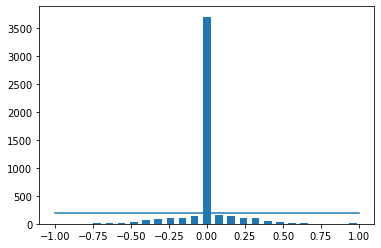

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data 4893
removed: 3505
remaining data:  1388


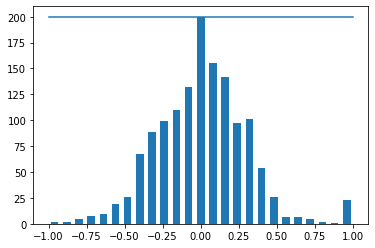

In [8]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1110
Valid Samples: 278


Text(0.5, 1.0, 'Validation set')

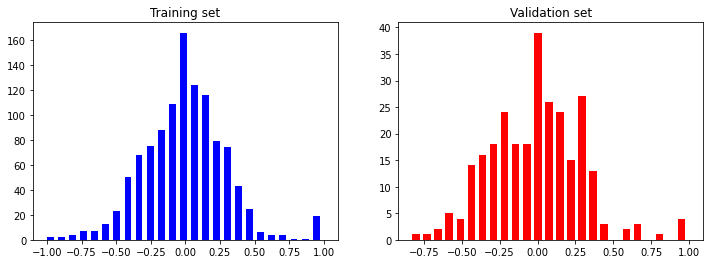

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [12]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


Text(0.5, 1.0, 'Zoomed image')

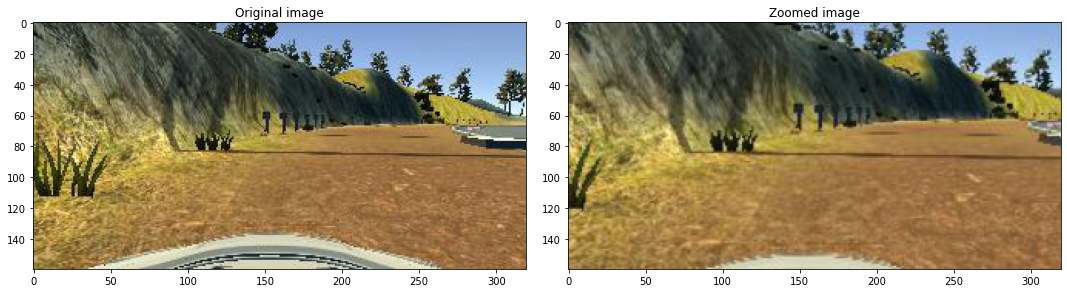

In [13]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

In [14]:
def pan(image):
   pan = iaa.Affine(translate_percent= {"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
   image = pan.augment_image(image)
   return image

Text(0.5, 1.0, 'Panned image')

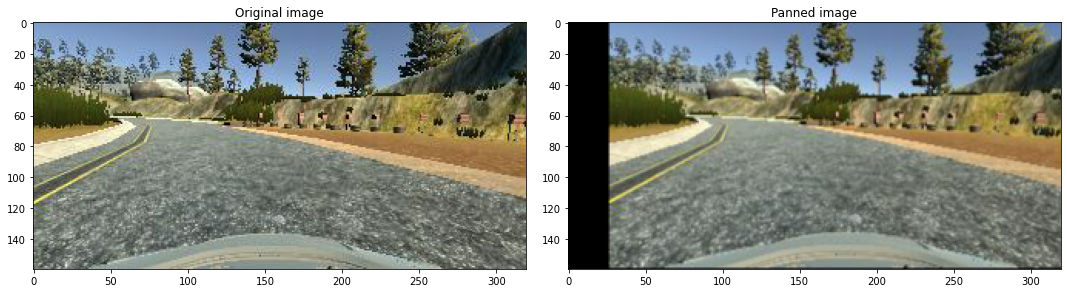

In [15]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [16]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image')

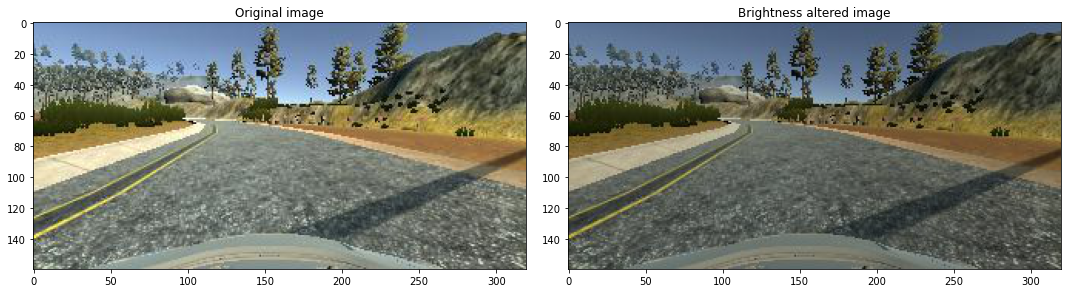

In [17]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

In [18]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = steering_angle * -1
    return image, steering_angle

Text(0.5, 1.0, 'Flipped imageSteering Angle: 0.2215374')

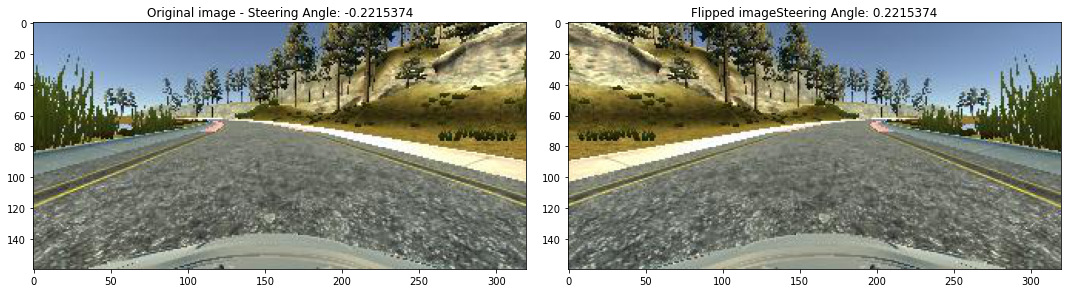

In [19]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image - ' + 'Steering Angle: ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped image' + 'Steering Angle: ' + str(flipped_steering_angle))

In [20]:
def random_augment(image, steering_angle): 
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle


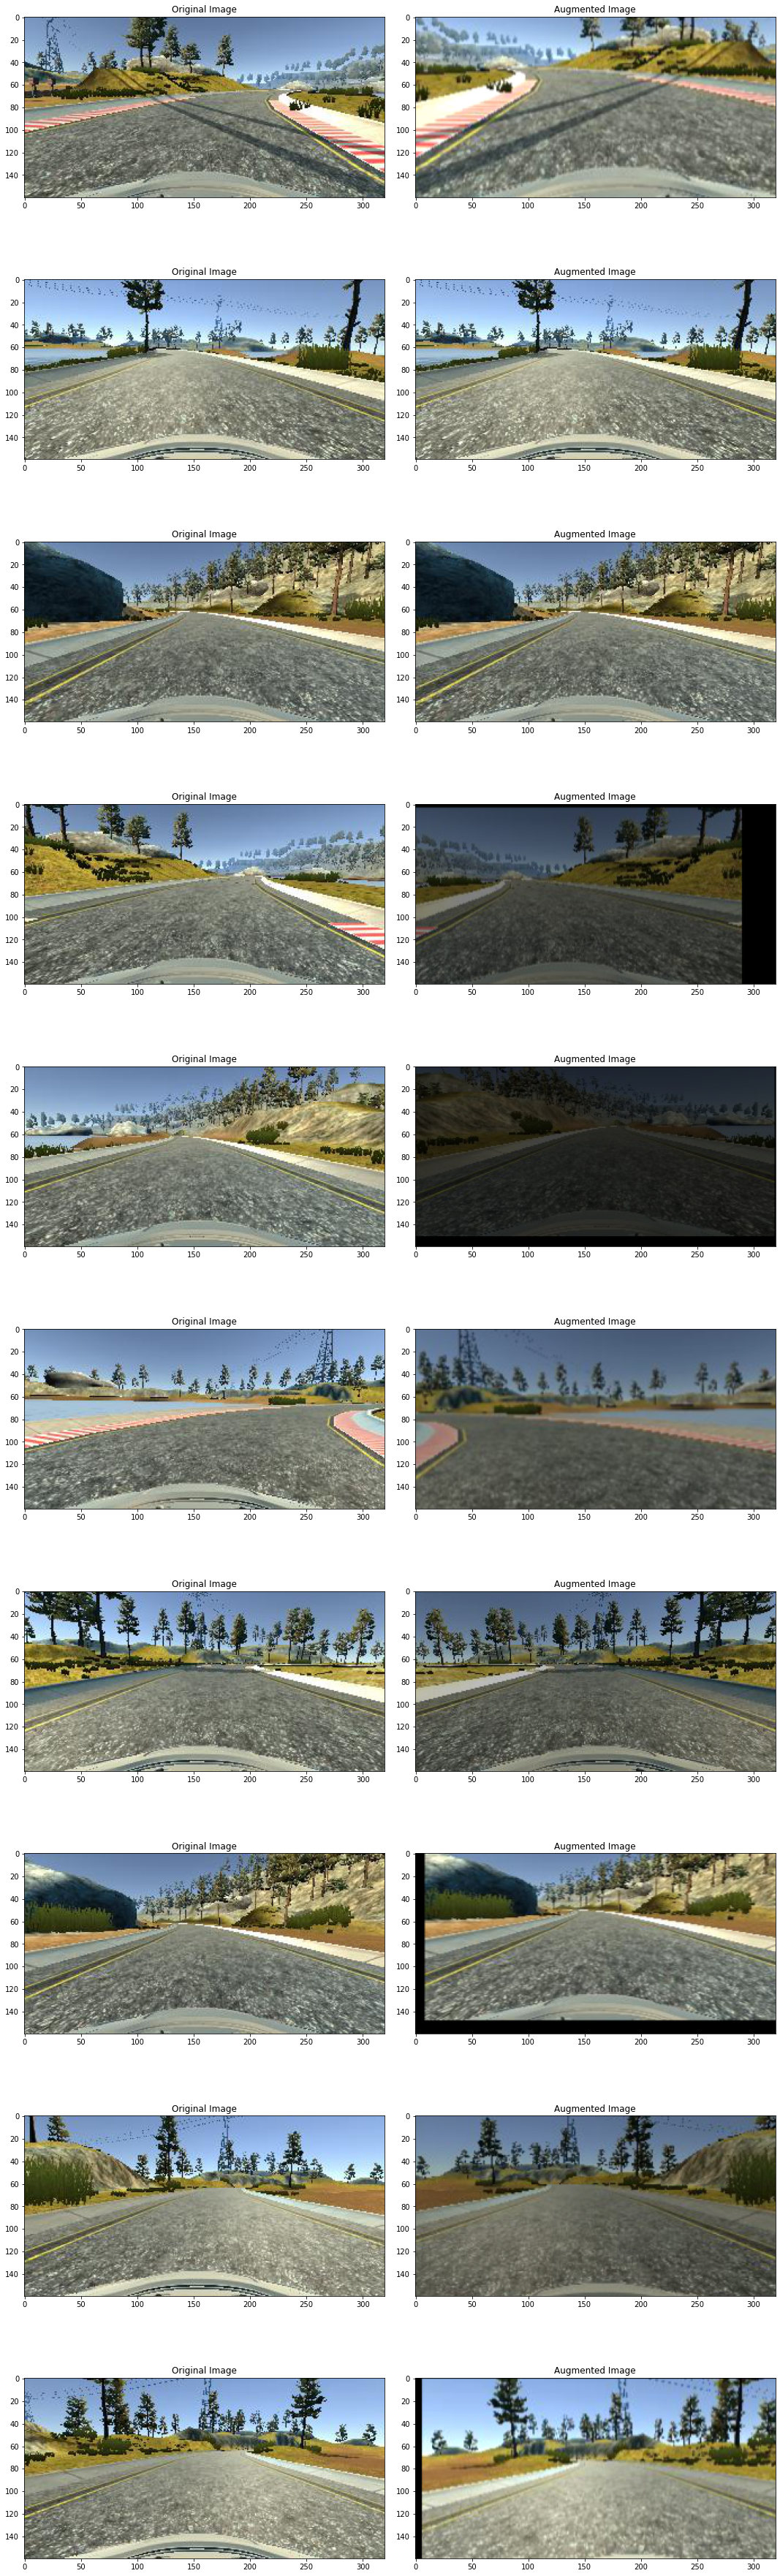

In [21]:

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings [randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image')

In [22]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed image')

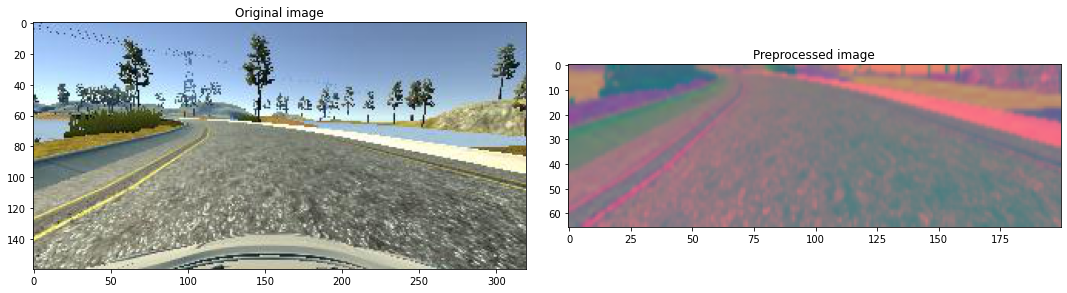

In [23]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [24]:
def batch_generator(image_paths, steering_ang, batch_size,  istraining):
    while True:
        batch_img = [] 
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation image')

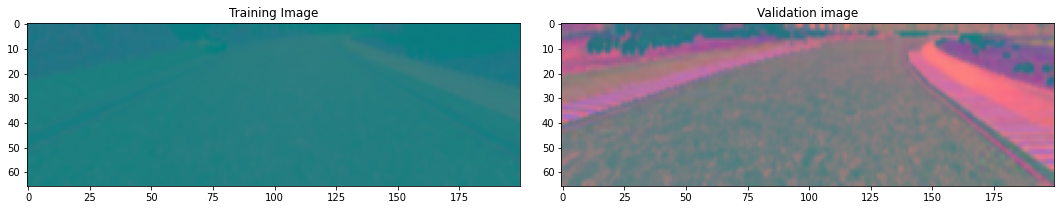

In [25]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_train, y_train, 1, 0))

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation image')

In [26]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, 5, strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
    
    model.add(Conv2D(36, 5, strides=(2,2), activation='elu'))
    model.add(Conv2D(48, 5, strides=(2,2), activation='elu'))
    model.add(Conv2D(64, 3, activation='elu'))
    model.add(Conv2D(64, 3, activation='elu'))
    #model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))
    
    
    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(10, activation ='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(1))
    
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [27]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), steps_per_epoch = 300, epochs = 10, validation_data=batch_generator(X_valid, y_valid, 100, 0), validation_steps = 200, verbose=1, shuffle=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
300/300 [==============================] - 137s 428ms/step - loss: 0.1175 - val_loss: 0.0644
Epoch 2/10
300/300 [==============================] - 128s 429ms/step - loss: 0.0648 - val_loss: 0.0472
Epoch 3/10
300/300 [==============================] - 127s 425ms/step - loss: 0.0620 - val_loss: 0.0391
Epoch 4/10
300/300 [==============================] - 129s 430ms/step - loss: 0.0548 - val_loss: 0.0451
Epoch 5/10
300/300 [==============================] - 125s 418ms/step - loss: 0.0477 - val_loss: 0.0397
Epoch 6/10
300/300 [==============================] - 127s 423ms/step - loss: 0.0425 - val_loss: 0.0324
Epoch 7/10
300/300 [==============================] - 127s 425ms/step - loss: 0.0378 - val_loss: 0.0308
Epoch 8/10
300/300 [==============================] - 127s 423ms/step - loss: 0.0386 - val_loss: 0.0334
Epoch 9/10
300/300 [==============================] - 127s 424ms/step - loss: 0.0375 - val_loss: 0.0318
Epoch 10/10
300/300 [==============================] - 126s 421m

Text(0.5, 0, 'Epoch')

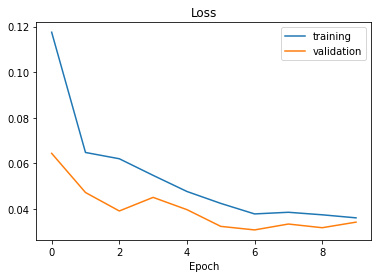

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [30]:
model.save('model.h5')

In [31]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>